In [19]:
from src.functions import *

In [20]:
plt.rcParams.update(
    {
        "xtick.direction": "in",
        "ytick.direction": "out",
        "ytick.right": False,
        "xtick.top": False,
        "ytick.left": True,
        "xtick.bottom": False,
        "figure.facecolor": "1",
        "savefig.facecolor": "1",
        "savefig.dpi": 600,
        "figure.dpi": 600,
        "savefig.bbox": "tight",
        "font.size": 7,
        "font.family": "serif",
        "lines.markersize": 4,
        "lines.linewidth": 1,
        'axes.axisbelow' : True
    }
)

In [22]:
data = load_from_json(f'data/delta_vs_t.json')
delta_quantum_arr = np.asarray(data['delta'])[:,1:]
qubits_range = data['qubits_range']
time_range = data['time_range'][1:]
T = data['T']
gammas = data['gammas']

In [23]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2, ddof=1) / np.sqrt(len(delta_quantum_arr[0,0]))

In [24]:
data_short_times = load_from_json(f'data/delta_vs_t_short_times.json')
delta_short_times_quantum_arr = np.asarray(data_short_times['delta'])[:,1:]
time_range_short_times = data_short_times['time_range'][1:]

In [25]:
delta_short_times_quantum_arr_avg = np.mean(delta_short_times_quantum_arr, axis=2)
delta_short_times_quantum_arr_std = np.std(delta_short_times_quantum_arr, axis=2, ddof=1) / np.sqrt(len(delta_short_times_quantum_arr[0,0]))

## $\delta$ vs $t$

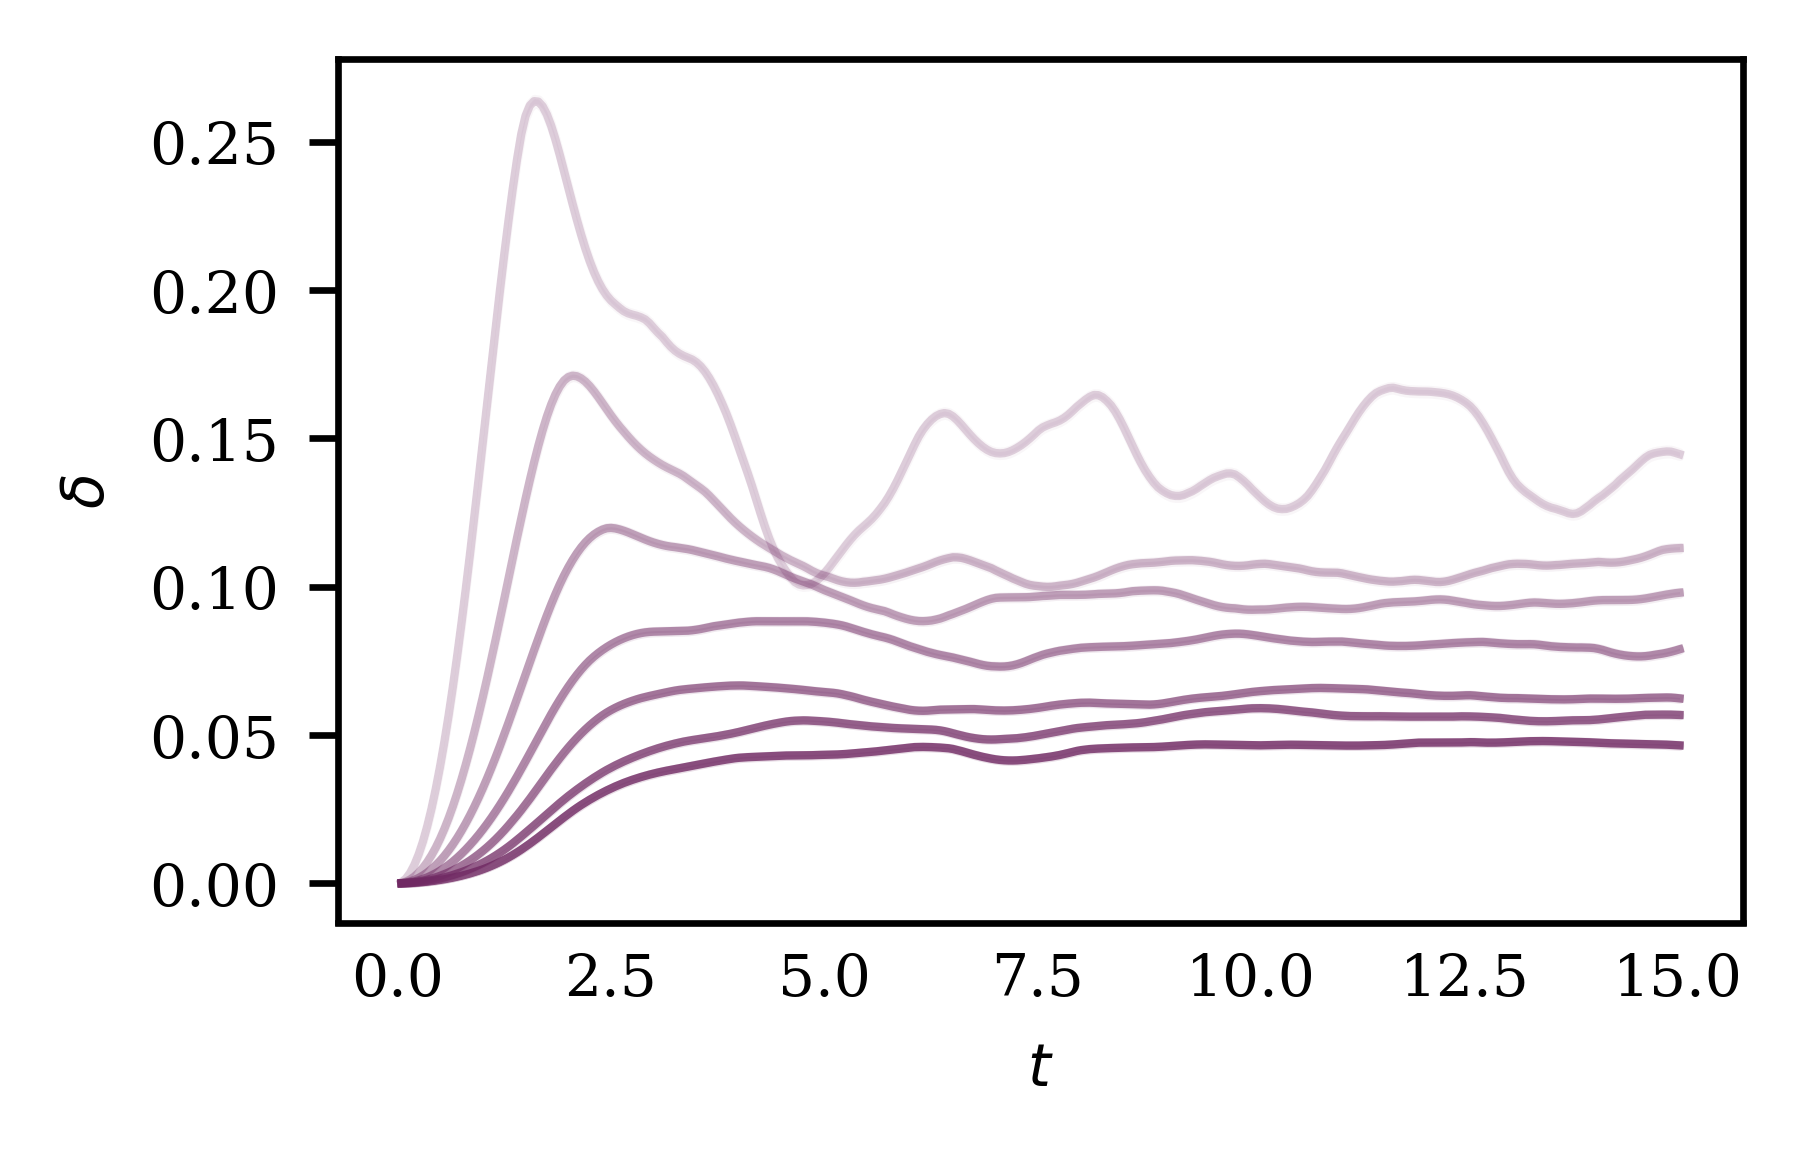

In [26]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range[:]):
    plt.plot(time_range[:300], 
            delta_quantum_arr_avg[n_id][:300],
            color=colors['purple'],
            label=f'n={n}',
            alpha=(0.2 + 0.1*n_id))
    plt.fill_between(time_range[:300], delta_quantum_arr_avg[n_id][:300]-delta_quantum_arr_std[n_id][:300]/10, delta_quantum_arr_avg[n_id][:300]+delta_quantum_arr_std[n_id][:300]/10, color=colors["purple"], alpha=(0.2 + 0.1*n_id)*0.2)

plt.xlabel('$t$')
plt.ylabel('$\delta$')
# plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_vs_t')

## $\delta$ / $t$

In [49]:
arg_opt = np.asarray([np.argmin(time_range_short_times / delta_short_times_quantum_arr_avg[n_id]) for n_id in range(len(qubits_range))])
t_opt_arr = np.asarray([time_range_short_times[i] for i in arg_opt])
delta_opt_arr = np.asarray([delta_short_times_quantum_arr_avg[i_id][i] for i_id, i in enumerate(arg_opt)])

In [50]:
len(delta_short_times_quantum_arr_avg[0])

999

In [51]:
t_err = time_range_short_times[1] - time_range_short_times[0]
t_err_arr = np.ones_like(time_range_short_times) * t_err

delta_err_arr = delta_short_times_quantum_arr_std
delta_over_t_arr = np.asarray([delta_short_times_quantum_arr_avg[n_id] / time_range_short_times for n_id in range(len(qubits_range))])
delta_over_t_opt_arr = delta_opt_arr / t_opt_arr
delta_over_t_err_arr = np.asarray([delta_over_t_arr[i] * np.sqrt((delta_err_arr[i] / delta_short_times_quantum_arr_avg[i])**2 + (t_err_arr / time_range_short_times)**2) for i in range(len(qubits_range))])
delta_over_t_opt_err_arr = np.asarray([delta_over_t_err_arr[i_id][i] for i_id, i in enumerate(arg_opt)])

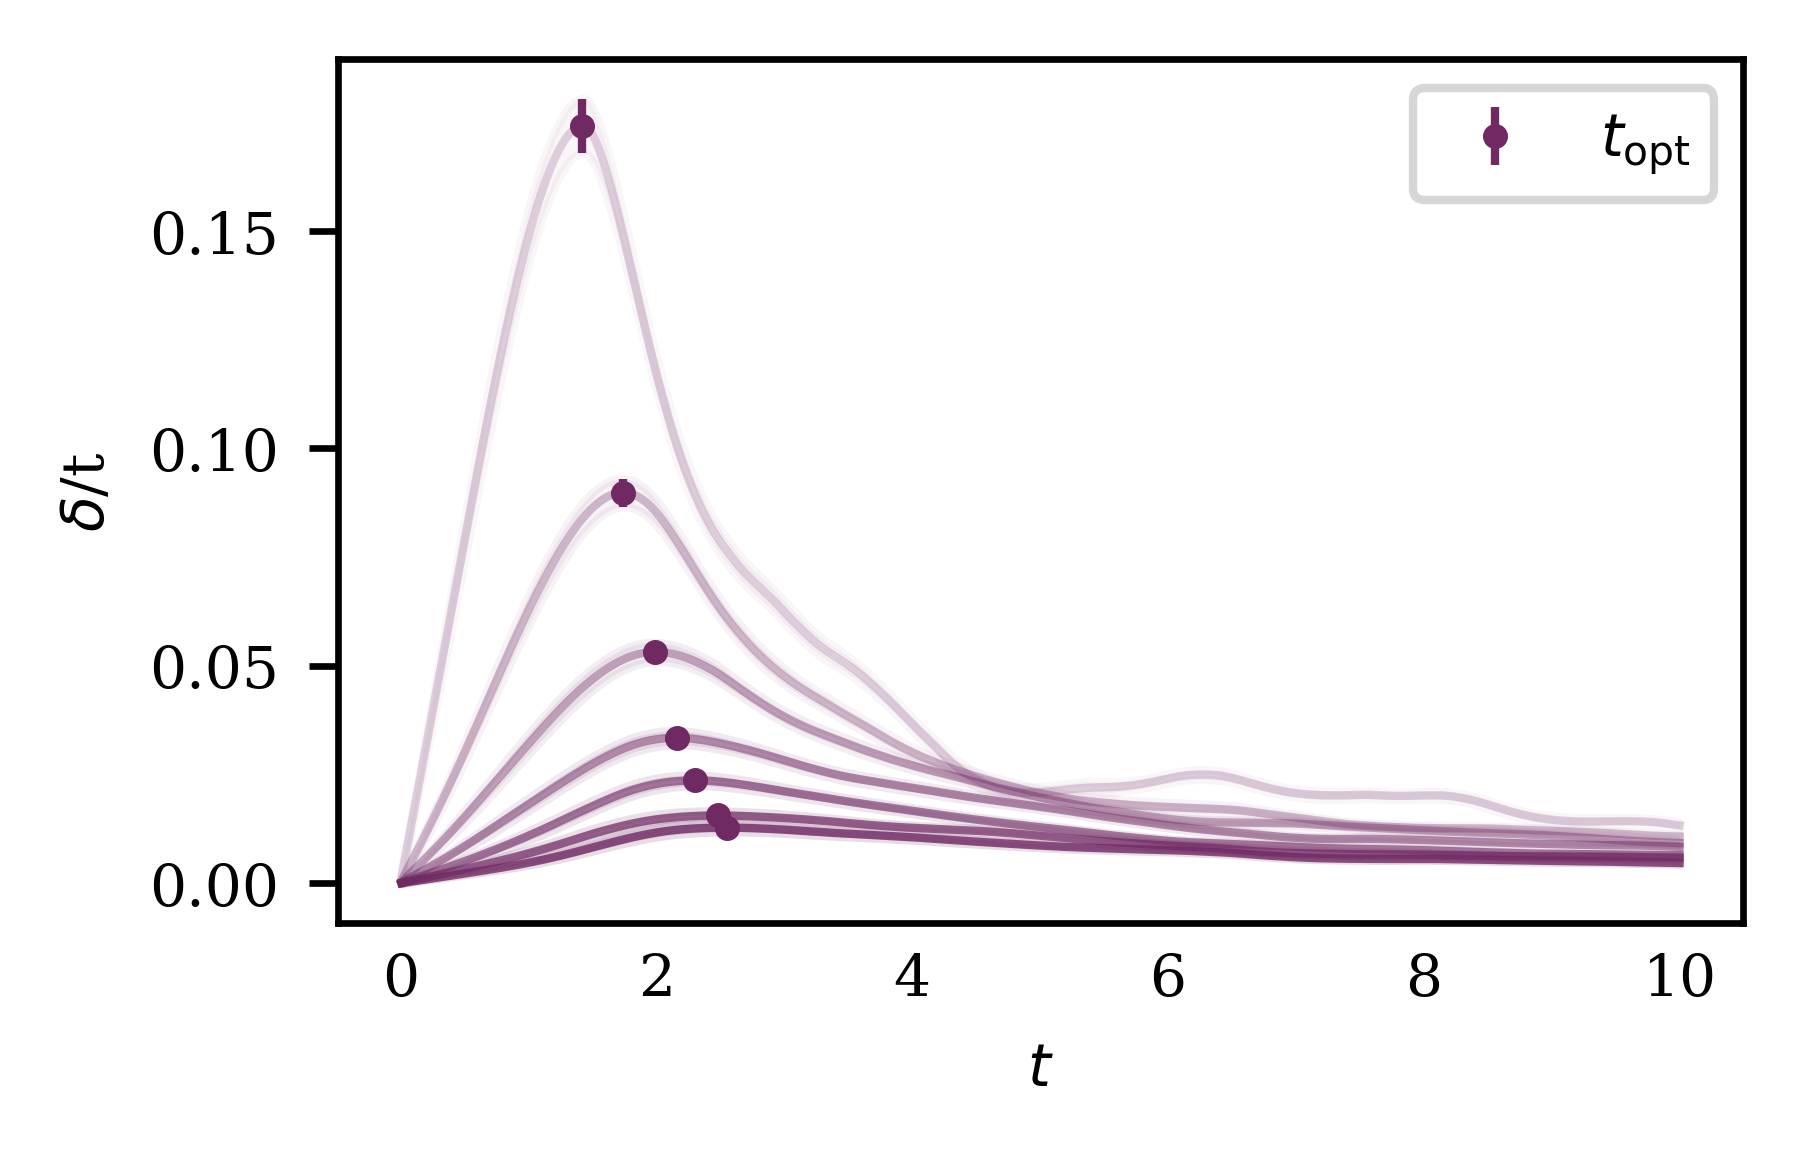

In [52]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range):
    plt.plot(time_range_short_times, 
             delta_over_t_arr[n_id],
             color=colors['purple'],
         #     label=f'n={n}',
             alpha=(0.2 + 0.1*n_id))
    plt.fill_between(time_range_short_times, 
                     delta_over_t_arr[n_id]-delta_over_t_err_arr[n_id], 
                     delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id],
                     color=colors['purple'],
                     alpha=(0.2 + 0.1*n_id)*0.2)

plt.errorbar(t_opt_arr, 
             delta_over_t_opt_arr, 
             delta_over_t_opt_err_arr,
             fmt='.', 
             color=colors['purple'],
             ms=4,
            #  capsize=2,
             label='$t_{\mathrm{opt}}$')

plt.xlabel('$t$')
plt.ylabel('$\delta$/t')
plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_over_t_vs_t')

## Finding optimal $t$

In [53]:
delta_over_t_ub_arr = np.asarray([delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id] for n_id, n in enumerate(qubits_range)])
ub_shifted = np.asarray([delta_over_t_ub_arr[n_id]-delta_over_t_opt_arr[n_id] for n_id, n in enumerate(qubits_range)])

In [54]:
indices_greater_than_zero = [np.where(ub_shifted[n_id] > 0)[0] for n_id, n in enumerate(qubits_range)]

In [55]:
id_lb = [indices_greater_than_zero[n_id][0] for n_id, n in enumerate(qubits_range)]
id_ub = [indices_greater_than_zero[n_id][-1] for n_id, n in enumerate(qubits_range)]
t_opt_err_arr = [time_range_short_times[id_ub[n_id]] - time_range_short_times[id_lb[n_id]] for n_id, n in enumerate(qubits_range)]

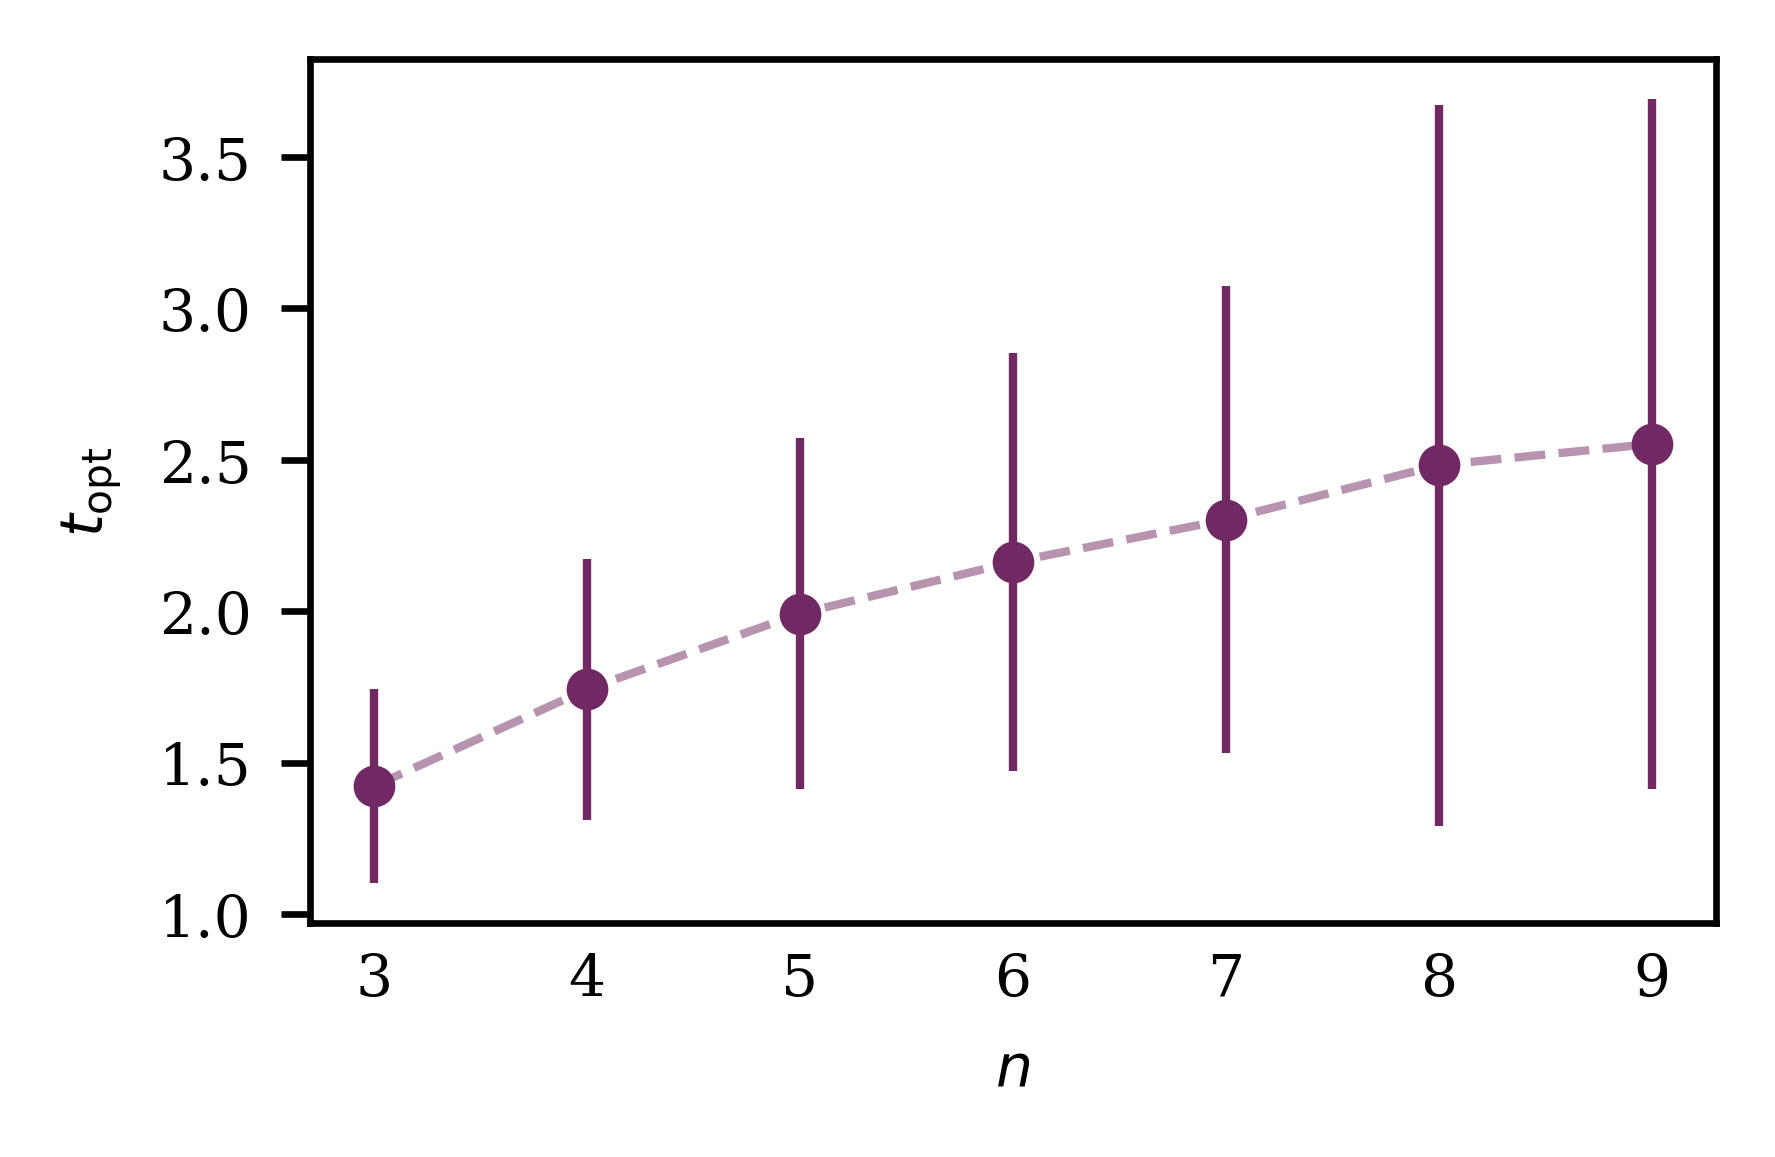

In [56]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

plt.plot(qubits_range, t_opt_arr, '--', color=colors['purple'], alpha=0.5)
plt.errorbar(qubits_range, 
             t_opt_arr, 
             yerr=t_opt_err_arr, 
             fmt='o', 
             c=colors['purple'],
             ms=4)
plt.xlabel('$n$')
plt.ylabel('$t_{\mathrm{opt}}$')
plt.xticks(qubits_range)
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/t_opt_vs_n')

## Combined panel

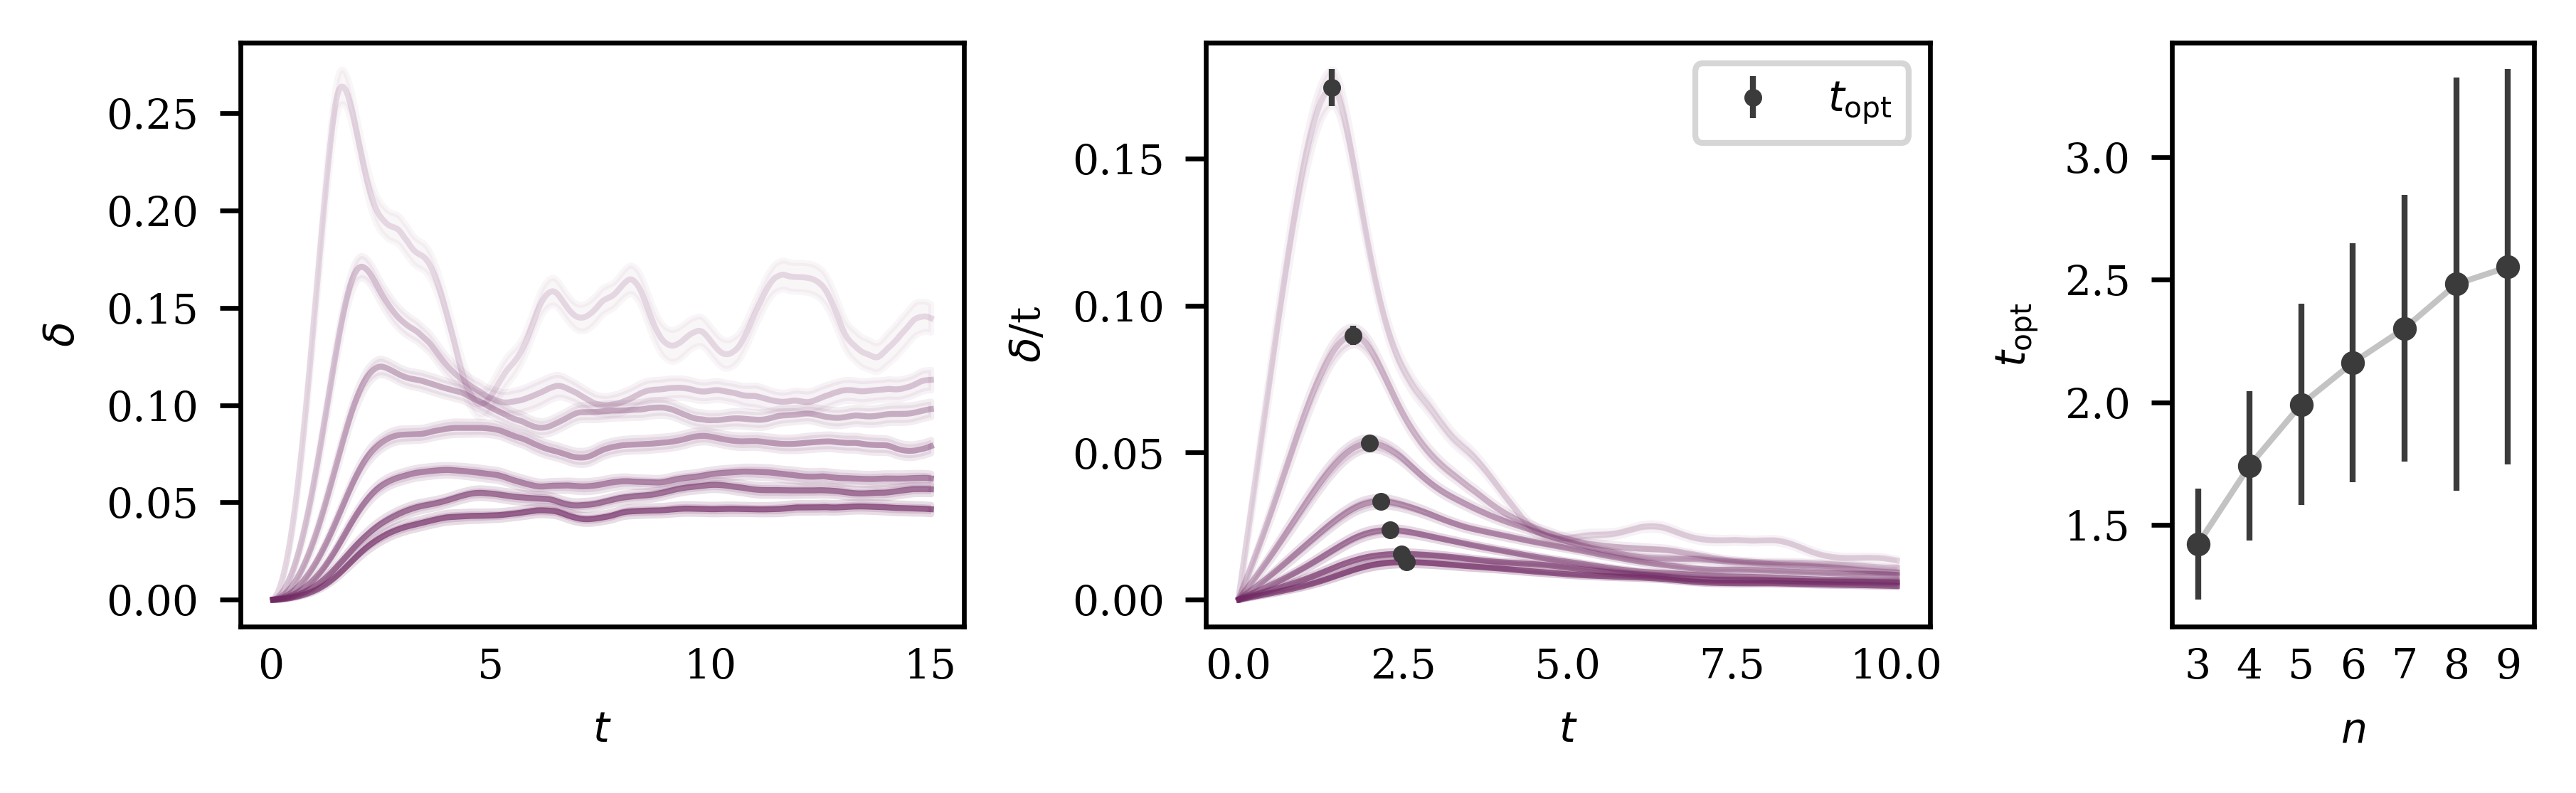

In [57]:
# Set up the 1x3 panel with shared width and height
fig, axes = plt.subplots(1, 3, figsize=(figure_size_x, figure_size_y/2), gridspec_kw={'width_ratios': [2,2,1]})

# First plot: Delta vs. time
for n_id, n in enumerate(qubits_range):
    axes[0].plot(time_range[:300], 
                 delta_quantum_arr_avg[n_id][:300],
                 color=colors['purple'],
                 label=f'n={n}',
                 alpha=(0.15 + 0.09 * n_id))
    axes[0].fill_between(time_range[:300], delta_quantum_arr_avg[n_id][:300]-delta_quantum_arr_std[n_id][:300], delta_quantum_arr_avg[n_id][:300]+delta_quantum_arr_std[n_id][:300], color=colors["purple"], alpha=(0.2 + 0.1*n_id)*0.2)

axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$\delta$')
# axes[0].legend()  # Uncomment to show legend

# Second plot: Delta over t vs. time with scatter plot
split = 100
for n_id, n in enumerate(qubits_range):
    axes[1].plot(time_range_short_times, 
                 delta_over_t_arr[n_id],
                 color=colors['purple'],
                 alpha=(0.15 + 0.09 * n_id))
    axes[1].fill_between(time_range_short_times, 
                        delta_over_t_arr[n_id]-delta_over_t_err_arr[n_id], 
                        delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id],
                        color=colors["purple"],
                        alpha=(0.2 + 0.1*n_id)*0.3)
axes[1].errorbar(t_opt_arr, 
                 delta_over_t_opt_arr, 
                 delta_over_t_opt_err_arr,
                 fmt='o', 
                 color="#3b3b3b",
                 ms=2,
                 label='$t_{\mathrm{opt}}$')

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\delta$/t')
axes[1].legend()

# Third plot: t_opt vs. qubit range with error bars
axes[2].plot(qubits_range, t_opt_arr, '-', color="#3b3b3b", alpha=0.3)
axes[2].errorbar(qubits_range, 
                 t_opt_arr, 
                 yerr=t_opt_err_arr/np.sqrt(2), 
                 fmt='o', 
                 c="#3b3b3b",
                 ms=3)
axes[2].set_xlabel('$n$')
axes[2].set_ylabel('$t_{\mathrm{opt}}$')
axes[2].set_xticks(qubits_range)
axes[2].set_xlim(2.5, 9.5)

# axes[2].set_xscale('log')

# Adjust layout to avoid overlapping
fig.tight_layout()

# Save the combined figure
fig.savefig(projectdir + 'figures/panel_delta_vs_t')

plt.show()


In [72]:
# Save optimal gammas
optimal_times = {}
for n_id, n in enumerate(range(3,10)):
    optimal_times[f'{n}'] = np.round(t_opt_arr[n_id], 7)

save_in_json(optimal_times, 'optimal_times.json')

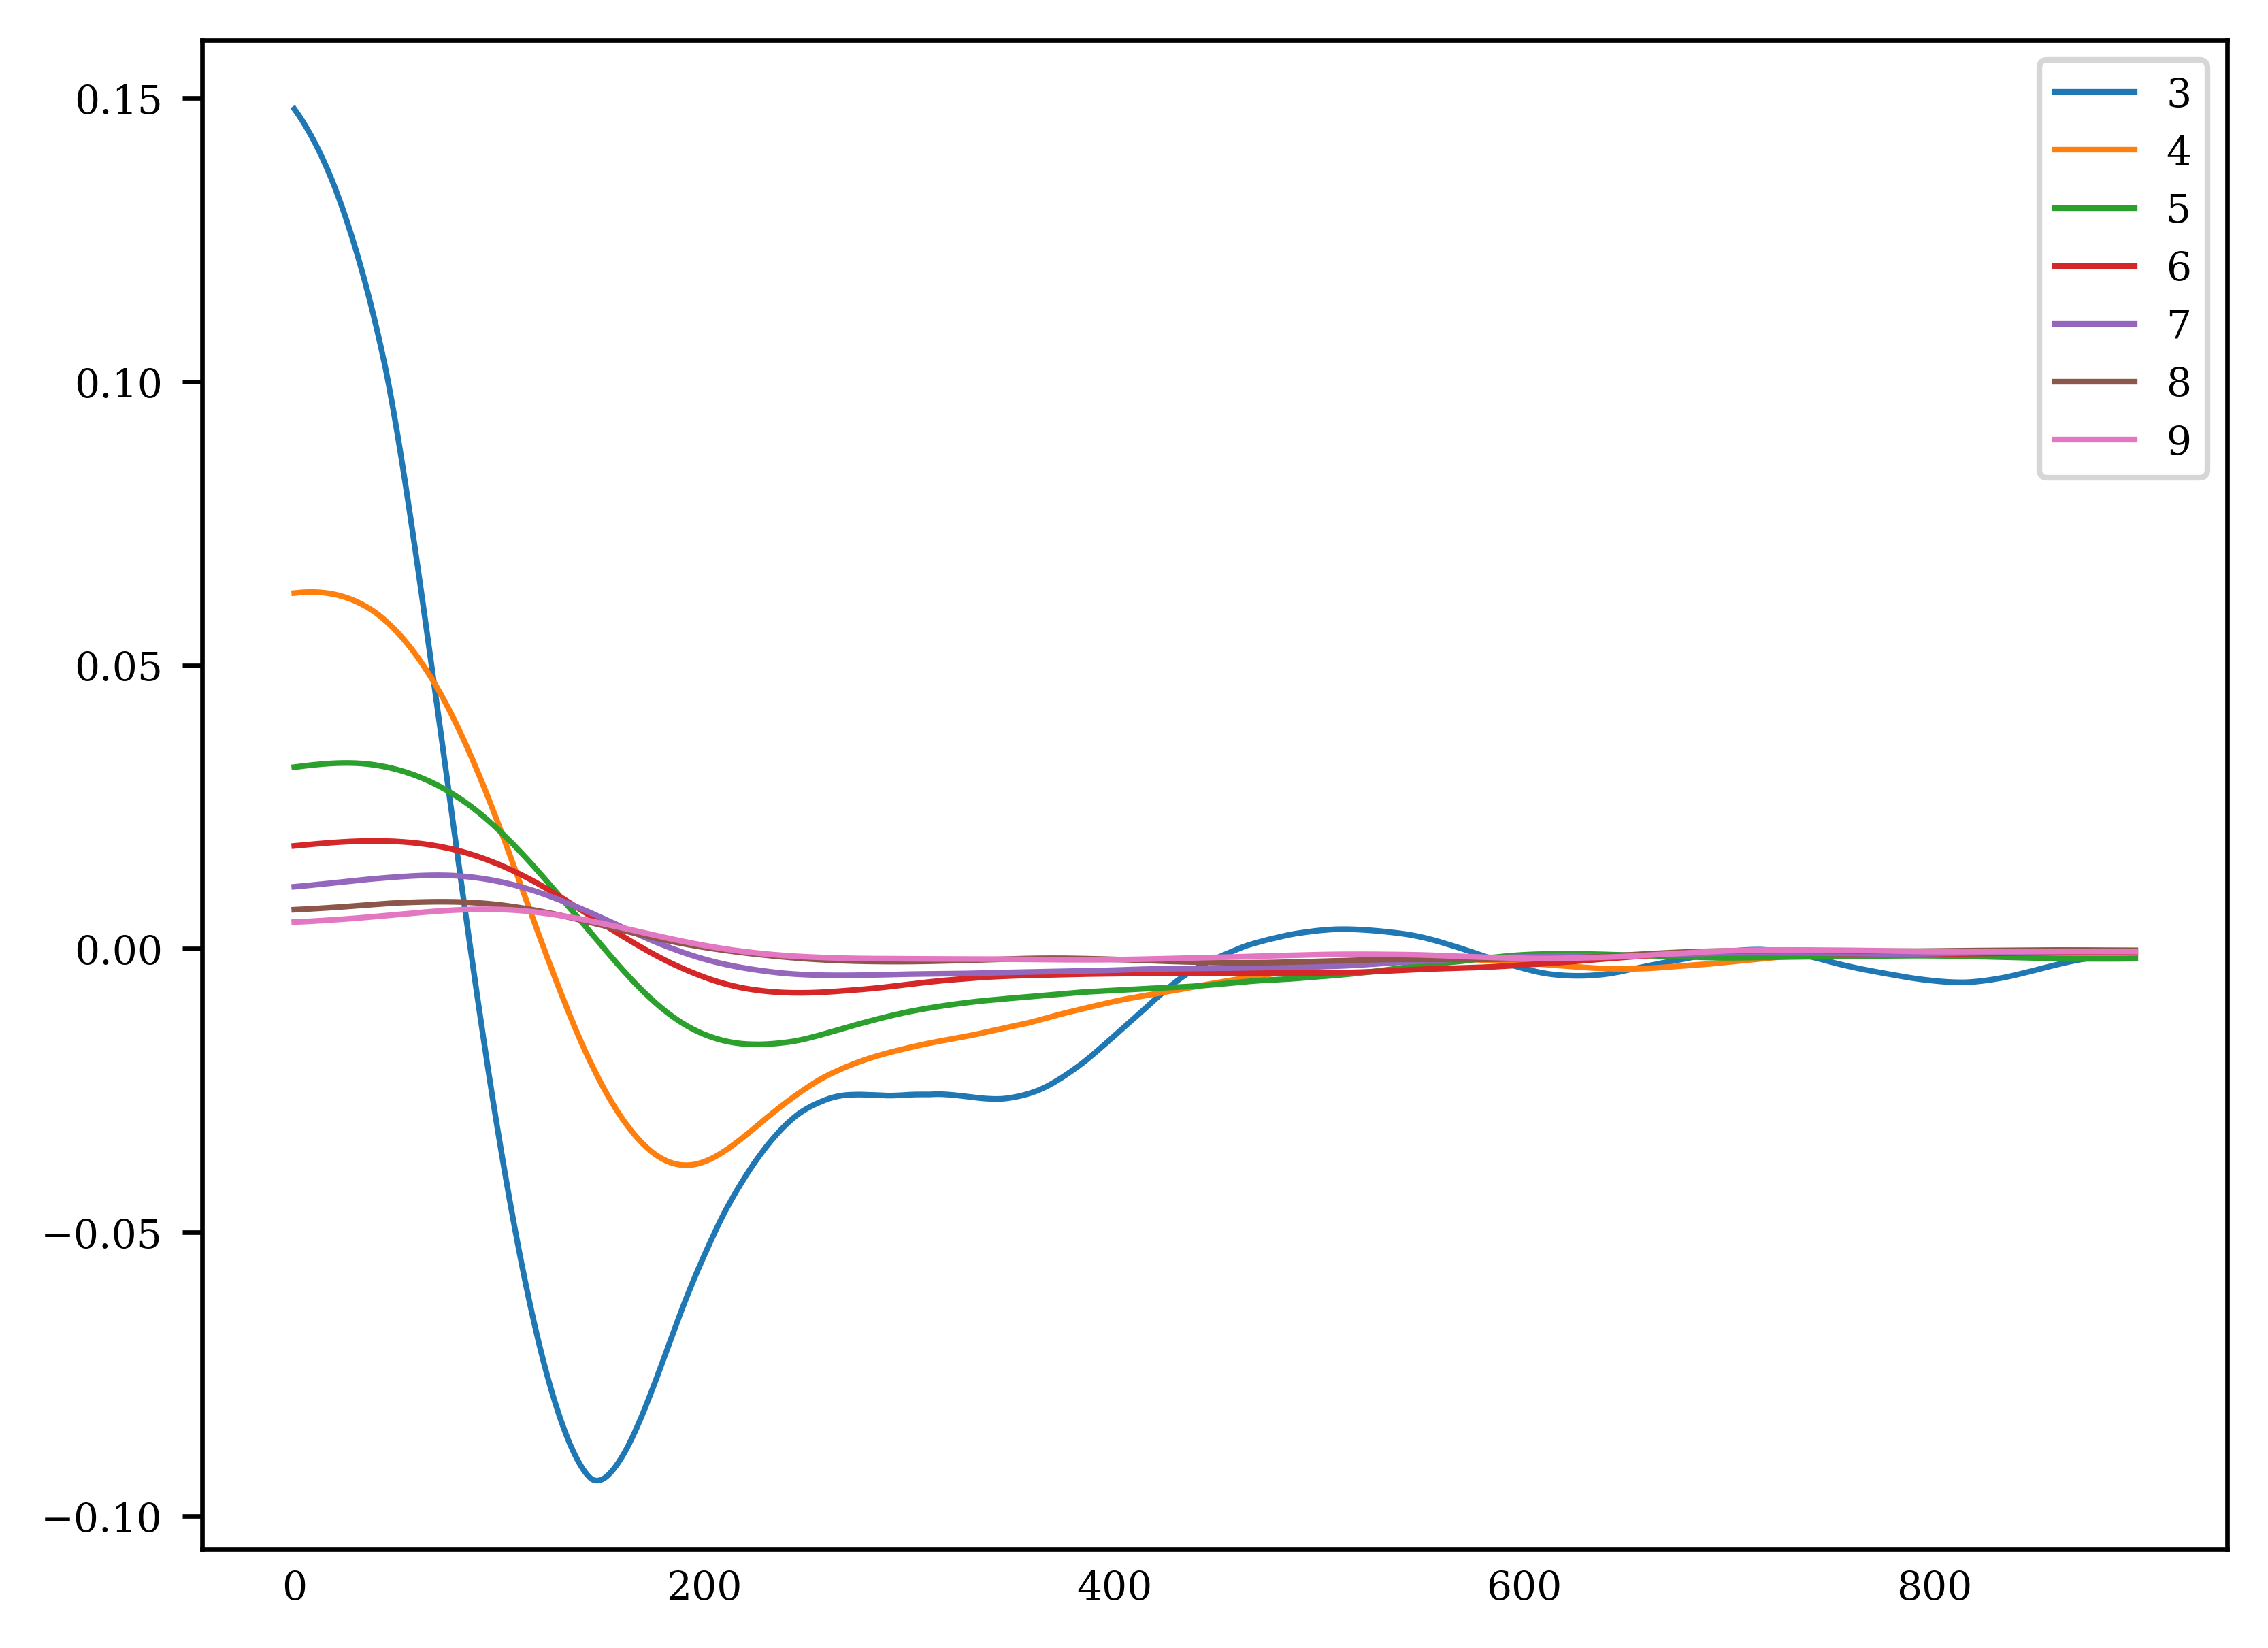

In [65]:
for n_id, n in enumerate(qubits_range):
    plt.plot(delta_over_t_arr[n_id][100:] - delta_over_t_arr[n_id][:-100], label=f'{n}')
plt.legend()